In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('YESBANK.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-07-12,13.18,14.00,12.00,12.17,10.848567,244941515
2005-07-13,12.20,12.60,11.49,11.74,10.465257,64111620
2005-07-14,12.00,12.00,11.40,11.45,10.206746,16282865
2005-07-15,11.25,12.89,11.25,12.37,11.026851,75448030
2005-07-18,12.54,13.14,12.50,12.82,11.427988,75684775


In [5]:
# to check dates in index
df.index

DatetimeIndex(['2005-07-12', '2005-07-13', '2005-07-14', '2005-07-15',
               '2005-07-18', '2005-07-19', '2005-07-20', '2005-07-21',
               '2005-07-22', '2005-07-25',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=4432, freq=None)

In [6]:
df.shape

(4432, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,16.200001,16.299999,15.95,16.000000,16.000000,52482954
2023-06-23,16.000000,16.100000,15.90,16.000000,16.000000,42620606
2023-06-26,16.049999,16.350000,16.00,16.100000,16.100000,69419649
2023-06-27,16.150000,16.250000,16.00,16.049999,16.049999,35114512
2023-06-30,16.250000,16.350000,16.15,16.250000,16.250000,68720948


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4432 entries, 2005-07-12 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4432 non-null   float64
 1   High       4432 non-null   float64
 2   Low        4432 non-null   float64
 3   Close      4432 non-null   float64
 4   Adj Close  4432 non-null   float64
 5   Volume     4432 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 242.4 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

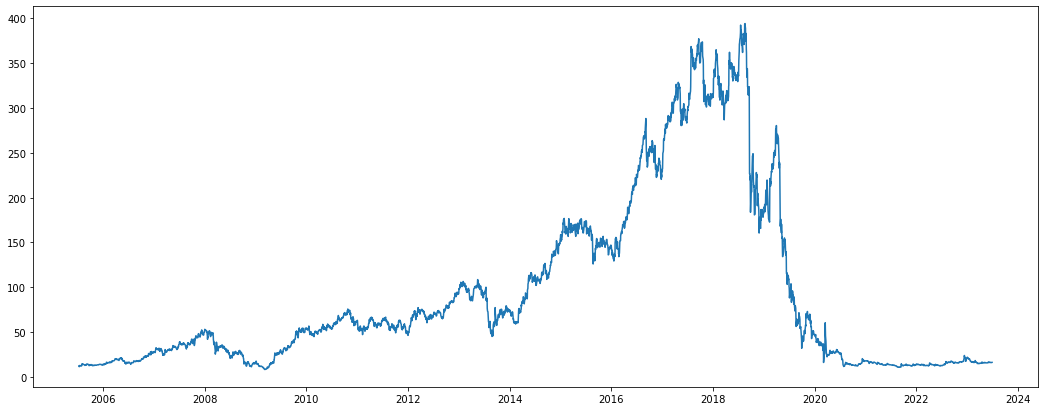

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  13.180000305175781
Ending price:  16.25


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  2005-07-12 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
2005-07-12,13.18,12.17
2005-07-13,12.20,11.74
2005-07-14,12.00,11.45
2005-07-15,11.25,12.37
2005-07-18,12.54,12.82


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[0.00998237],
       [0.00886746],
       [0.00811554],
       ...,
       [0.02017217],
       [0.02004252],
       [0.02056109]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(3102, 1330)

In [21]:
train_data

array([[0.00998237],
       [0.00886746],
       [0.00811554],
       ...,
       [0.86932173],
       [0.85674653],
       [0.84157849]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[0.00998237, 0.00886746, 0.00811554, ..., 0.0156088 , 0.01553101,
        0.0150643 ],
       [0.00886746, 0.00811554, 0.01050093, ..., 0.01553101, 0.0150643 ,
        0.01457167],
       [0.00811554, 0.01050093, 0.0116677 , ..., 0.0150643 , 0.01457167,
        0.01550508],
       ...,
       [0.80061192, 0.84144889, 0.8433935 , ..., 0.89460176, 0.89732419,
        0.91158472],
       [0.84144889, 0.8433935 , 0.86348788, ..., 0.89732419, 0.91158472,
        0.88345257],
       [0.8433935 , 0.86348788, 0.85946896, ..., 0.91158472, 0.88345257,
        0.86932173]])

In [25]:
y_train

array([0.01457167, 0.01550508, 0.01558287, ..., 0.88345257, 0.86932173,
       0.85674653])

In [26]:
X_test

array([[0.84702344, 0.82252123, 0.84806055, ..., 0.7872589 , 0.77844324,
        0.76470131],
       [0.82252123, 0.84806055, 0.8090386 , ..., 0.77844324, 0.76470131,
        0.78518459],
       [0.84806055, 0.8090386 , 0.8076125 , ..., 0.76470131, 0.78518459,
        0.78946274],
       ...,
       [0.01887575, 0.0196536 , 0.0196536 , ..., 0.02056109, 0.02043145,
        0.01991288],
       [0.0196536 , 0.0196536 , 0.02043145, ..., 0.02043145, 0.01991288,
        0.01991288],
       [0.0196536 , 0.02043145, 0.02069073, ..., 0.01991288, 0.01991288,
        0.02017217]])

In [27]:
print(X_train.shape) 

(3081, 20)


In [28]:
print(y_train.shape)

(3081,)


In [29]:
print(X_test.shape)

(1309, 20)


In [30]:
print(ytest.shape)

(1309,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(3081, 20, 1)

In [33]:
X_train

array([[[0.00998237],
        [0.00886746],
        [0.00811554],
        ...,
        [0.0156088 ],
        [0.01553101],
        [0.0150643 ]],

       [[0.00886746],
        [0.00811554],
        [0.01050093],
        ...,
        [0.01553101],
        [0.0150643 ],
        [0.01457167]],

       [[0.00811554],
        [0.01050093],
        [0.0116677 ],
        ...,
        [0.0150643 ],
        [0.01457167],
        [0.01550508]],

       ...,

       [[0.80061192],
        [0.84144889],
        [0.8433935 ],
        ...,
        [0.89460176],
        [0.89732419],
        [0.91158472]],

       [[0.84144889],
        [0.8433935 ],
        [0.86348788],
        ...,
        [0.89732419],
        [0.91158472],
        [0.88345257]],

       [[0.8433935 ],
        [0.86348788],
        [0.85946896],
        ...,
        [0.91158472],
        [0.88345257],
        [0.86932173]]])

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
97/97 [==============================] - 4s 19ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 2/100
97/97 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 9.4784e-04
Epoch 3/100
97/97 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/100
97/97 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/100
97/97 [==============================] - 1s 13ms/step - loss: 8.8037e-04 - val_loss: 8.0615e-04
Epoch 6/100
97/97 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 8.5223e-04
Epoch 7/100
97/97 [==============================] - 1s 13ms/step - loss: 8.6323e-04 - val_loss: 7.1332e-04
Epoch 8/100
97/97 [==============================] - 1s 13ms/step - loss: 8.8505e-04 - val_loss: 7.4294e-04
Epoch 9/100
97/97 [==============================] - 1s 13ms/step - loss: 7.7673e-04 - val_loss: 6.9588e-04
Epoch 10/100
97/97 [==============================] - 1s 14m

97/97 [==============================] - 1s 13ms/step - loss: 3.5951e-04 - val_loss: 3.0032e-04
Epoch 77/100
97/97 [==============================] - 1s 13ms/step - loss: 3.5761e-04 - val_loss: 3.1786e-04
Epoch 78/100
97/97 [==============================] - 1s 13ms/step - loss: 3.9300e-04 - val_loss: 4.2772e-04
Epoch 79/100
97/97 [==============================] - 1s 13ms/step - loss: 3.9521e-04 - val_loss: 2.5661e-04
Epoch 80/100
97/97 [==============================] - 1s 13ms/step - loss: 3.8046e-04 - val_loss: 2.6571e-04
Epoch 81/100
97/97 [==============================] - 1s 13ms/step - loss: 3.4802e-04 - val_loss: 2.7686e-04
Epoch 82/100
97/97 [==============================] - 1s 13ms/step - loss: 4.1087e-04 - val_loss: 3.1081e-04
Epoch 83/100
97/97 [==============================] - 1s 13ms/step - loss: 4.0563e-04 - val_loss: 2.6127e-04
Epoch 84/100
97/97 [==============================] - 1s 13ms/step - loss: 3.6240e-04 - val_loss: 2.5120e-04
Epoch 85/100
97/97 [============

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

41/41 [==============================] - 0s 5ms/step


In [39]:
train_predict

array([[0.01555383],
       [0.01512036],
       [0.0151387 ],
       ...,
       [0.8908157 ],
       [0.88062006],
       [0.8651482 ]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[ 14.318802],
       [ 14.15162 ],
       [ 14.158694],
       ...,
       [351.8898  ],
       [347.95755 ],
       [341.99036 ]], dtype=float32)

In [42]:
test_predict

array([[301.7518  ],
       [304.2976  ],
       [307.6107  ],
       ...,
       [ 16.027489],
       [ 15.954151],
       [ 15.955823]], dtype=float32)

In [43]:
ytest

array([0.78518459, 0.78946274, 0.80514936, ..., 0.01991288, 0.02017217,
       0.02004252])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


130.28824276379996

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

133.99850146097492

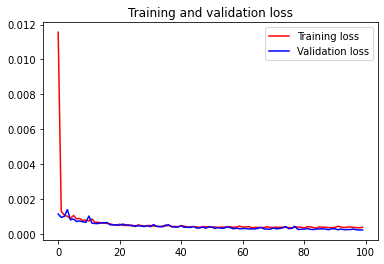

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

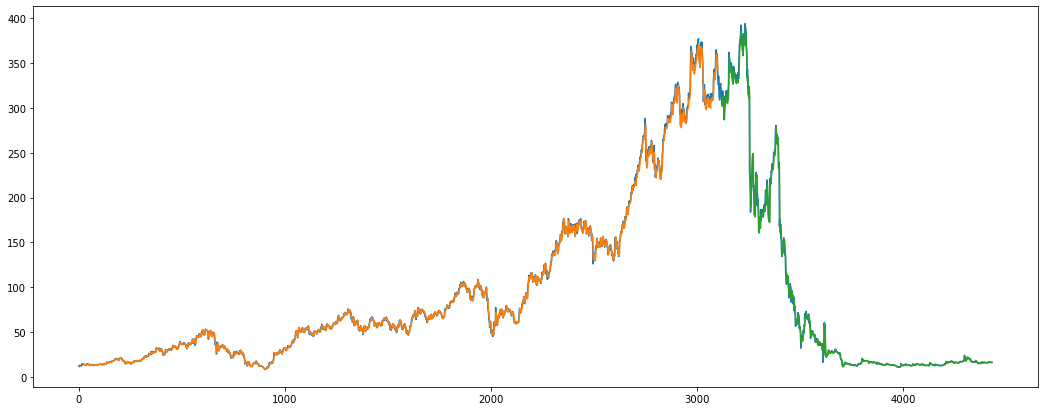

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.78518459, 0.78946274, 0.80514936, ..., 0.01991288, 0.02017217,
       0.02004252])

In [49]:
test_predict

array([[301.7518  ],
       [304.2976  ],
       [307.6107  ],
       ...,
       [ 16.027489],
       [ 15.954151],
       [ 15.955823]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

1309

In [52]:
test_predict1

array([301.7518  , 304.2976  , 307.6107  , ...,  16.027489,  15.954151,
        15.955823], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.78518459, 0.78946274, 0.80514936, ..., 0.01991288, 0.02017217,
        0.02004252]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[311.1499939 , 312.79998779, 318.8500061 , ...,  16.        ,
         16.10000038,  16.04999924]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

1309

In [60]:
df2 = df.iloc[3123:,:]

In [61]:
len(df2)

1309

In [62]:
df2.head()

,Open,Close
Date,,
2018-03-13,310.000000,312.799988
2018-03-14,311.799988,318.850006
2018-03-15,318.950012,311.850006
2018-03-16,312.399994,312.899994
2018-03-19,316.000000,304.799988


In [63]:
df2['predicted'] = test_predict1

In [64]:
df2.head(20)

,Open,Close,predicted
Date,,,
2018-03-13,310.000000,312.799988,301.751801
2018-03-14,311.799988,318.850006,304.297607
2018-03-15,318.950012,311.850006,307.610687
2018-03-16,312.399994,312.899994,312.955231
2018-03-19,316.000000,304.799988,311.784302
2018-03-20,303.000000,302.399994,310.586151
2018-03-21,305.000000,300.750000,305.143738
2018-03-22,301.799988,298.250000,300.458221
2018-03-23,293.000000,286.649994,297.457336


In [65]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1309 entries, 2018-03-13 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1309 non-null   float64
 1   Close      1309 non-null   float64
 2   predicted  1309 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 35.8 KB


In [66]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,16.200001,16.000000,16.132545
2023-06-23,16.000000,16.000000,16.124241
2023-06-26,16.049999,16.100000,16.027489
2023-06-27,16.150000,16.049999,15.954151
2023-06-30,16.250000,16.250000,15.955823


In [67]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [68]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2018-03-13,310.000000,312.799988,301.751801,-11.048187
2018-03-14,311.799988,318.850006,304.297607,-14.552399
2018-03-15,318.950012,311.850006,307.610687,-4.239319
2018-03-16,312.399994,312.899994,312.955231,0.055237
2018-03-19,316.000000,304.799988,311.784302,6.984314


In [69]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [70]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2018-03-13,310.000000,312.799988,301.751801,-11.048187,0
2018-03-14,311.799988,318.850006,304.297607,-14.552399,0
2018-03-15,318.950012,311.850006,307.610687,-4.239319,0
2018-03-16,312.399994,312.899994,312.955231,0.055237,1
2018-03-19,316.000000,304.799988,311.784302,6.984314,1


In [71]:
df2.drop(columns='temp_signal',inplace = True)

In [72]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2018-03-13,310.000000,312.799988,301.751801,0
2018-03-14,311.799988,318.850006,304.297607,0
2018-03-15,318.950012,311.850006,307.610687,0
2018-03-16,312.399994,312.899994,312.955231,1
2018-03-19,316.000000,304.799988,311.784302,1


In [73]:
signal = list(df2['signal'])

In [74]:
signal

[0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,


In [75]:
signal.insert(0,999)

In [76]:
signal

[999,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0

In [77]:
len(df2)

1309

In [78]:
len(signal)

1310

In [79]:
signal.pop()

0

In [80]:
len(signal)

1309

In [81]:
new_signal = np.array(signal)

In [82]:
new_signal

array([999,   0,   0, ...,   1,   0,   0])

In [83]:
df2['new_signal'] = new_signal

In [84]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2018-03-13,310.000000,312.799988,301.751801,0,999
2018-03-14,311.799988,318.850006,304.297607,0,0
2018-03-15,318.950012,311.850006,307.610687,0,0
2018-03-16,312.399994,312.899994,312.955231,1,0
2018-03-19,316.000000,304.799988,311.784302,1,1


In [85]:
df2.drop(columns = 'signal',inplace = True)

In [86]:
df3 = df2[df2['new_signal']==1]

In [87]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2018-03-19,316.000000,304.799988,311.784302,1
2018-03-20,303.000000,302.399994,310.586151,1
2018-03-21,305.000000,300.750000,305.143738,1
2018-03-22,301.799988,298.250000,300.458221,1
2018-03-23,293.000000,286.649994,297.457336,1


In [88]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [89]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2018-03-19,316.000000,304.799988,311.784302,1,-11.200012
2018-03-20,303.000000,302.399994,310.586151,1,-0.600006
2018-03-21,305.000000,300.750000,305.143738,1,-4.250000
2018-03-22,301.799988,298.250000,300.458221,1,-3.549988
2018-03-23,293.000000,286.649994,297.457336,1,-6.350006


In [90]:
df3['profit_loss'].sum()

-276.3501205444336

In [91]:
df4 = df2[df2['new_signal']==0]

In [92]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [93]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2018-03-14,311.799988,318.850006,304.297607,0,-7.050018
2018-03-15,318.950012,311.850006,307.610687,0,7.100006
2018-03-16,312.399994,312.899994,312.955231,0,-0.500000
2018-03-27,307.000000,303.500000,287.860321,0,3.500000
2018-03-28,300.149994,304.850006,293.148041,0,-4.700012


In [94]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2018-03-13,310.000000,312.799988,301.751801,999
2018-03-14,311.799988,318.850006,304.297607,0
2018-03-15,318.950012,311.850006,307.610687,0
2018-03-16,312.399994,312.899994,312.955231,0
2018-03-19,316.000000,304.799988,311.784302,1


In [95]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,16.200001,16.000000,16.132545,0
2023-06-23,16.000000,16.000000,16.124241,1
2023-06-26,16.049999,16.100000,16.027489,1
2023-06-27,16.150000,16.049999,15.954151,0
2023-06-30,16.250000,16.250000,15.955823,0


In [96]:
df4['profit_loss'].sum()

303.30002784729004

In [97]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [98]:
Total_profit

26.949907302856445

In [99]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  310.0
Ending price:  15.955822944641113


In [100]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

-294.0441770553589

In [101]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

320.99408435821533

In [102]:
len(df3)

612

In [103]:
len(df4)

696

In [104]:
len(df2)

1309